In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import corner
import h5py
import multiprocessing as multi
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.integrate import cumtrapz
from sklearn.mixture import GaussianMixture
import seaborn as sns
import sys
from true_params import true_params, uncert
import tqdm

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

In [3]:
with h5py.File('thetas.h5', 'r') as f:
    thetas = array(f['Theta'])
thetas = sort(concatenate((thetas, [0,1])))
ticum = interp1d(linspace(0, 1, len(thetas)), thetas)

with h5py.File('optimal_snr.h5', 'r') as f:
    ms = array(f['ms'])
    rhos = array(f['SNR'])
oint = RectBivariateSpline(ms, ms, rhos)

In [4]:
oint.ev(array([1,2,3]), array([2,3,4]))

array([3.39704894, 5.34188423, 7.06473383])

In [5]:
def softening(x, x0, s):
    return exp(-0.5*square((log(x)-log(x0))/s))
def soft_pl_unnorm(x, a, x0, x1, s0, s1):
    pl = x**a
    
    sl = where(x < x0, softening(x, x0, s0), 1.0)
    sh = where(x > x1, softening(x, x1, s1), 1.0)
    
    return pl*sl*sh
def draw_soft_pl(N, a, x0, x1, s0, s1):
    xs = exp(linspace(log(x0)-5*s0, log(x1) + 5*s1, 1000))
    pls = soft_pl_unnorm(xs, a, x0, x1, s0, s1)
    cpls = cumtrapz(pls, xs, initial=0)
    icdf = interp1d(cpls, xs)
    
    return icdf(cpls[-1]*rand(N))
def draw_soft_pl_max(ys, a, x0, x1, s0, s1):
    xs = exp(linspace(log(x0)-5*s0, log(x1) + 5*s1, 1000))
    pls = soft_pl_unnorm(xs, a, x0, x1, s0, s1)
    cpls = cumtrapz(pls, xs, initial=0)
    cdf = interp1d(xs, cpls)
    icdf = interp1d(cpls, xs)
    
    cmaxs = cdf(ys)
    
    return icdf(cmaxs*rand(len(ys)))
def draw_z(R0, g, H0, Om, w, zmax):
    zs = expm1(linspace(log(1), log(1+zmax), 1000))
    c = cosmo.wCDM(H0*u.km/u.s/u.Mpc, Om, 1.0-Om, w)
    dNdz = R0*4.0*pi*c.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value*(1+zs)**(g-1)
    N = trapz(dNdz, zs)
    zcum = cumtrapz(dNdz, zs, initial=0)
    
    icum = interp1d(zcum, zs)
    
    n = random.poisson(N)
    return icum(N*rand(n))
def mc_eta_from_m1m2(m1, m2):
    mt = m1+m2
    eta = m1*m2/(mt*mt)
    mc = mt*eta**(0.6)
    return mc, eta
def m1m2_from_mc_eta(mc, eta):
    mt = mc/eta**(0.6)
    
    disc = 1-4*eta
    sd = sqrt(disc)
    m1 = 0.5*mt*(1+sd)
    m2 = 0.5*mt*(1-sd)
    return m1, m2
def draw(R0, MMin, MMax, alpha, beta, gamma, sl, sh, H0, Om, w):
    ztrue = draw_z(R0, gamma, H0, Om, w, 2)
    ctrue = cosmo.wCDM(H0*u.km/u.s/u.Mpc, Om, 1-Om, w)
    dltrue = ctrue.luminosity_distance(ztrue).to(u.Gpc).value
    m1true = draw_soft_pl(len(ztrue), -alpha, MMin, MMax, sl, sh)
    m2true = draw_soft_pl_max(m1true, beta, MMin, MMax, sl, sh)
    m1trueobs = m1true*(1+ztrue)
    m2trueobs = m2true*(1+ztrue)
    thetatrue = ticum(rand(len(m1trueobs)))
    
    rhotrue = thetatrue*oint.ev(m1trueobs, m2trueobs)/dltrue
    
    rhoobs = rhotrue + randn(len(rhotrue))
    
    sel = rhoobs > 8
    
    ztrue = ztrue[sel]
    dltrue = dltrue[sel]
    m1true = m1true[sel]
    m2true = m2true[sel]
    m1trueobs = m1trueobs[sel]
    m2trueobs = m2trueobs[sel]
    rhotrue = rhotrue[sel]
    thetatrue = thetatrue[sel]
    rhoobs = rhoobs[sel]
    
    mctrueobs, etatrue = mc_eta_from_m1m2(m1trueobs, m2trueobs)
    
    smc = abs(uncert['threshold_snr']/rhoobs*uncert['mc'])
    mcobs = random.lognormal(mean=log(mctrueobs), sigma=smc)
    
    se = abs(uncert['threshold_snr']/rhoobs*uncert['eta'])
    etobs = etatrue + se*randn(len(se))
    while np.any(etobs > 0.25) or np.any(etobs < 0):
        s = (etobs > 0.25) | (etobs < 0)
        etobs[s] = etatrue[s] + se[s]*randn(len(se[s]))
    
    m1obs, m2obs = m1m2_from_mc_eta(mcobs, etobs)

    st = abs(uncert['threshold_snr']/rhoobs*uncert['Theta'])
    thetaobs = thetatrue + st*randn(len(st))
    while np.any(thetaobs < 0) or np.any(thetaobs > 1):
        s = (thetaobs < 0) | (thetaobs > 1)
        thetaobs[s] = thetatrue[s] + st[s]*randn(len(st[s]))
    
    dlobs = thetaobs*oint.ev(m1obs, m2obs)/rhoobs
    
    return m1obs, m2obs, dlobs, thetaobs

Number after 1 year = 894


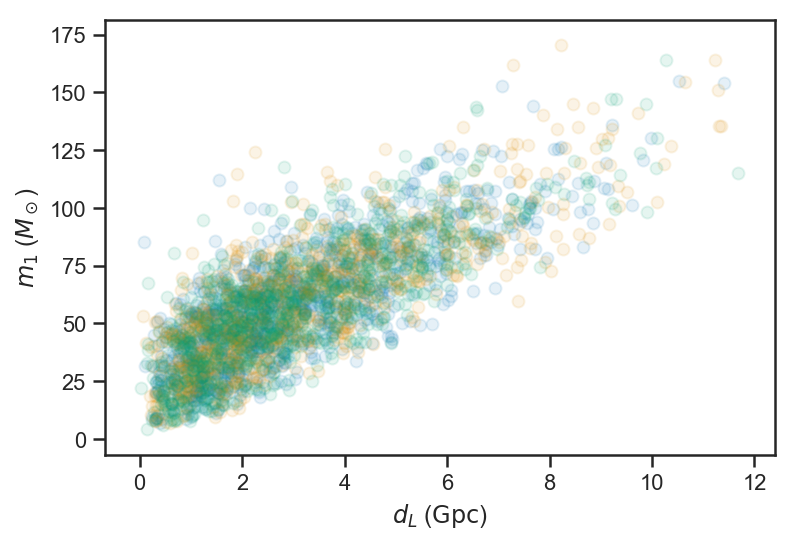

In [6]:
m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -1)
print('Number after 1 year = {:d}'.format(len(m1)))
scatter(dl, m1, alpha=0.1)
ylabel(r'$m_1$ ($M_\odot$)')
xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -1.1)
scatter(dl, m1, alpha=0.1)
m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -0.9)
scatter(dl, m1, alpha=0.1)

In [7]:
def compress(m1, dl):
    bins = sort(concatenate((percentile(dl, [10, 20, 30, 40, 50, 60, 70, 80, 90]), [0.0, 1.01*np.max(dl)])))
    cent = 0.5*(bins[1:]+bins[:-1])
    
    ds = []
    mm = []
    m9 = []
    for l, h in zip(bins[:-1], bins[1:]):
        s = (l <= dl) & (dl < h)
        ds.append(median(dl[s]))
        mm.append(median(m1[s]))
        m9.append(percentile(m1[s], 90))
    
    return len(m1), array(ds), array(mm), array(m9)

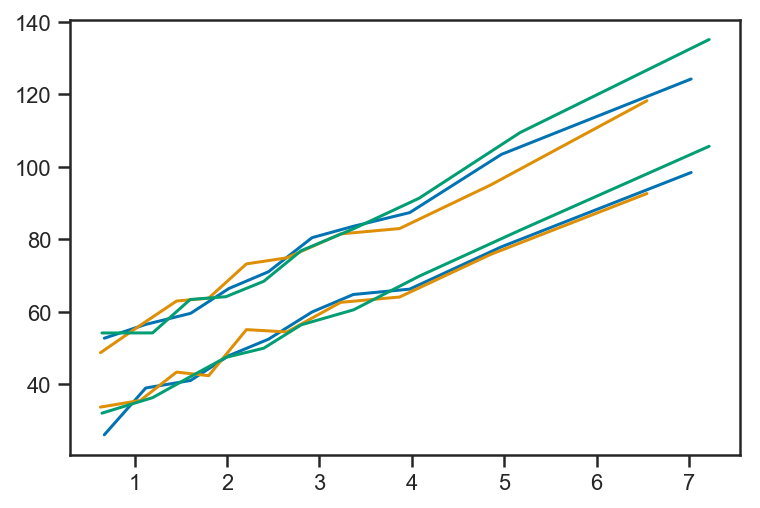

In [8]:
m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -1)
_, c, m, s = compress(m1, dl)
l, = plot(c, m)
plot(c, s, color=l.get_color())

m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -1.2)
_, c, m, s = compress(m1, dl)
l, = plot(c, m)
plot(c, s, color=l.get_color())

m1, m2, dl, t = draw(0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, 70.0, 0.3, -0.8)
n, c, m, s = compress(m1, dl)
l, = plot(c, m)
plot(c, s, color=l.get_color())

In [9]:
p0_1yr = array([0.5*100, 5.0, 40.0, 0.75, 0.0, 3.0, 0.1, 0.1, Planck15.H0.to(u.km/u.s/u.Mpc).value, Planck15.Om0, -1.0])
dp0 = array([0.5*10, 0.5, 4.0, 0.075, 0.1, 0.3, 0.05, 0.05, 1.0, 0.05, 0.1])

def draw_prior(i=None):
    H0 = Planck15.H0.to(u.km/u.s/u.Mpc).value*(1+0.01*randn())
    Omh2 = Planck15.Om0*(H0/100)**2*(1 + 0.01*randn())
    Om = Omh2/(H0/100)**2
    return p0_1yr + array([0.5*20*randn(), randn(), 8*randn(), randn(), randn(), randn(), 0.03*randn(), 0.03*randn(), H0-Planck15.H0.to(u.km/u.s/u.Mpc).value, Om - Planck15.Om0, 0.5*randn()])

In [10]:
def data_mean_and_cov(p_and_seed):
    p, seed = p_and_seed
    state = random.get_state()
    try:
        random.seed(seed)
        draws = []
        for i in range(256):
            m1, m2, dl, t = draw(*p)
            n, d, mm, m9 = compress(m1, dl)
            draws.append(concatenate(([n], d, mm, m9)))
        draws = array(draws)
    finally:
        random.set_state(state)
    return mean(draws, axis=0), cov(draws, rowvar=False)        

In [11]:
ps = [p0_1yr]
for i in range(len(p0_1yr)):
    p = p0_1yr.copy()
    p[i] += dp0[i]
    ps.append(p)

In [12]:
pool = multi.Pool()
try:
    seed = randint(1<<30)
    means_and_covs = list(tqdm.tqdm(pool.imap(data_mean_and_cov, [(p, seed) for p in ps]), total=len(ps)))
finally:
    pool.close()

100%|██████████| 12/12 [07:09<00:00, 35.76s/it]


In [13]:
means, covs = zip(*means_and_covs)
means = array(means)
covs = array(covs)

dmu = []
dcov = []
for i, dp in enumerate(dp0):
    dmu.append((means[i+1,...]-means[0,...])/dp)
    dcov.append((covs[i+1,...]-covs[0,...])/dp)
mu = means[0,...]
covv = covs[0,...]
dmu = array(dmu)
dcov = array(dcov)

In [14]:
def compress2(d):
    r = d - mu
    rw = np.linalg.solve(covv, r)
    return np.dot(dmu, rw) + 0.5*np.dot(rw, np.dot(dcov, rw).T)

In [18]:
m1, m2, dl, t = draw(*p0_1yr)
n, d, mm, m9 = compress(m1, dl)
t = compress2(concatenate(([n], d, mm, m9)))

In [23]:
def get_compressed_from_prior(i=None):
    p = draw_prior()
    m1, m2, dl, t = draw(*p)
    n, d, mm, m9 = compress(m1, dl)
    return concatenate((p, compress2(concatenate(([n], d, mm, m9)))))

In [ ]:
ndim = 2*t.shape[0]
ndraw = 1 << 17

p = multi.Pool()
try:
    pts = list(tqdm.tqdm(p.imap_unordered(get_compressed_from_prior, range(ndraw)), total=ndraw))
finally:
    p.close()

  0%|          | 254/131072 [00:34<10:23:03,  3.50it/s]

In [47]:
pts = array(pts)
pts.shape

(131072, 22)

In [48]:
with h5py.File('lfi.h5', 'w') as f:
    f.create_dataset('prior_draws', data=pts, compression='gzip', shuffle=True)
    
    f.create_dataset('mu', data=mu, compression='gzip', shuffle=True)
    f.create_dataset('dmu', data=dmu, compression='gzip', shuffle=True)
    f.create_dataset('cov', data=covv, compression='gzip', shuffle=True)
    f.create_dataset('dcov', data=dcov, compression='gzip', shuffle=True)
    
    f.create_dataset('m1', data=m1, compression='gzip', shuffle=True)
    f.create_dataset('m2', data=m2, compression='gzip', shuffle=True)
    f.create_dataset('dl', data=dl, compression='gzip', shuffle=True)

    f.create_dataset('t', data=t, compression='gzip', shuffle=True)

In [56]:
gmms = [GaussianMixture(i) for i in range(5, 8)]

In [57]:
ntest = int(round(0.1*pts.shape[0]))
test = pts[:ntest,:]
train = pts[ntest:,:]

In [59]:
for g in gmms:
    g.fit(train)

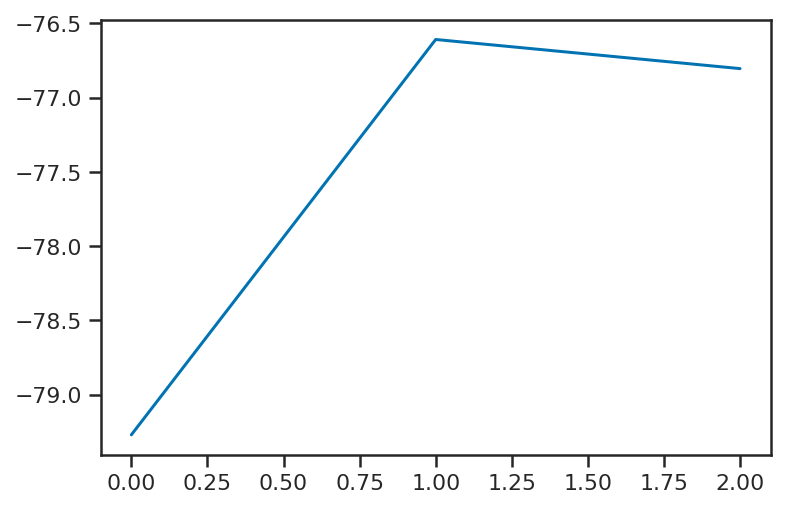

In [60]:
plot([g.score(test) for g in gmms])

The below is an implementation of a conditional GMM, conditioned on the observed data, `t`.  
Let the mean and sigma of the unconditional distribution be partitioned as 
$$
\mu = \begin{pmatrix} \mu_1 \\ \mu_2 \end{pmatrix},
$$
and
$$
\Sigma = \begin{pmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{pmatrix}
$$

In [ ]:
class ConditionedGMM(object):
    def __init__(self, gmm, t):
        self._gmm = gmm
        
        self._nd = t.shape[0]
        self._np = t.shape[0]
        
        self._weights = []
        self._means = []
        self._covariances = []
        
        n = t.shape[0]
        
        for w, m, c in zip(self.gmm.weights_, self.gmm.means_, self.gmm.covariances_):
            c11 = c[:n, :n]
            c12 = c[:n, n:]
            c21 = c[n:, :n]
            c22 = c[n:, n:]
            
            